<h2>1. Data preparetion</h2>

Firstly, the dataset is obtained from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html), the German Traffic Sign Recognition Benchmark GTSRB dataset. The file downloaded includes training images with lable, test images, and ground truth for the test images.

The path to the dataset is loaded below:

In [1]:
train_directory = r'C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\Training'
ground_truth = r"C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\GT-final_test.csv"
test_directory = r'C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\Final_Test\Images'

Some libraries is needed for training the model:

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd

from PIL import Image
import shutil

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50 
from keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

The test images is first extracted and stored as numpy arrays:

In [3]:
image_paths = glob.glob(os.path.join(train_directory, '**', '*.ppm'), recursive=True)

images = []
labels = []

for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    images.append(image)

    label = int(image_path.split(os.sep)[-2])
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

print("Loaded", len(images), "images and", len(labels), "labels.")

Loaded 26640 images and 26640 labels.


Ground truth for every test file is also loaded in a pandas dataframe:

In [4]:
ground_truth_df = pd.read_csv(ground_truth, delimiter=";")

print(ground_truth_df.head())

    Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


Test images are extracted and stored in numpy dataframe:

In [5]:
test_files = sorted(os.listdir(test_directory))
test_images = []

for test_file in test_files:
    image_path = os.path.join(test_directory, test_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping file: {image_path}")
        continue
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    test_images.append(image)
test_images = np.array(test_images)

print("Loaded", len(test_images), "test images.")

Skipping file: C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\Final_Test\Images\GT-final_test.test.csv
Loaded 12630 test images.


The lable to be predicted will be the class ids stored in the ground truth dataframe.:

In [6]:
class_ids = ground_truth_df['ClassId'].values
X_test = test_images
y_test = class_ids

The shape of training and testing dataset is checked:

In [7]:
print("Training dataset:")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("="*20)
print("Testing dataset:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training dataset:
Images shape: (26640, 32, 32, 3)
Labels shape: (26640,)
Testing dataset:
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


To visualise the data, a random sample of 3 images from 10 random classes in training dataset:

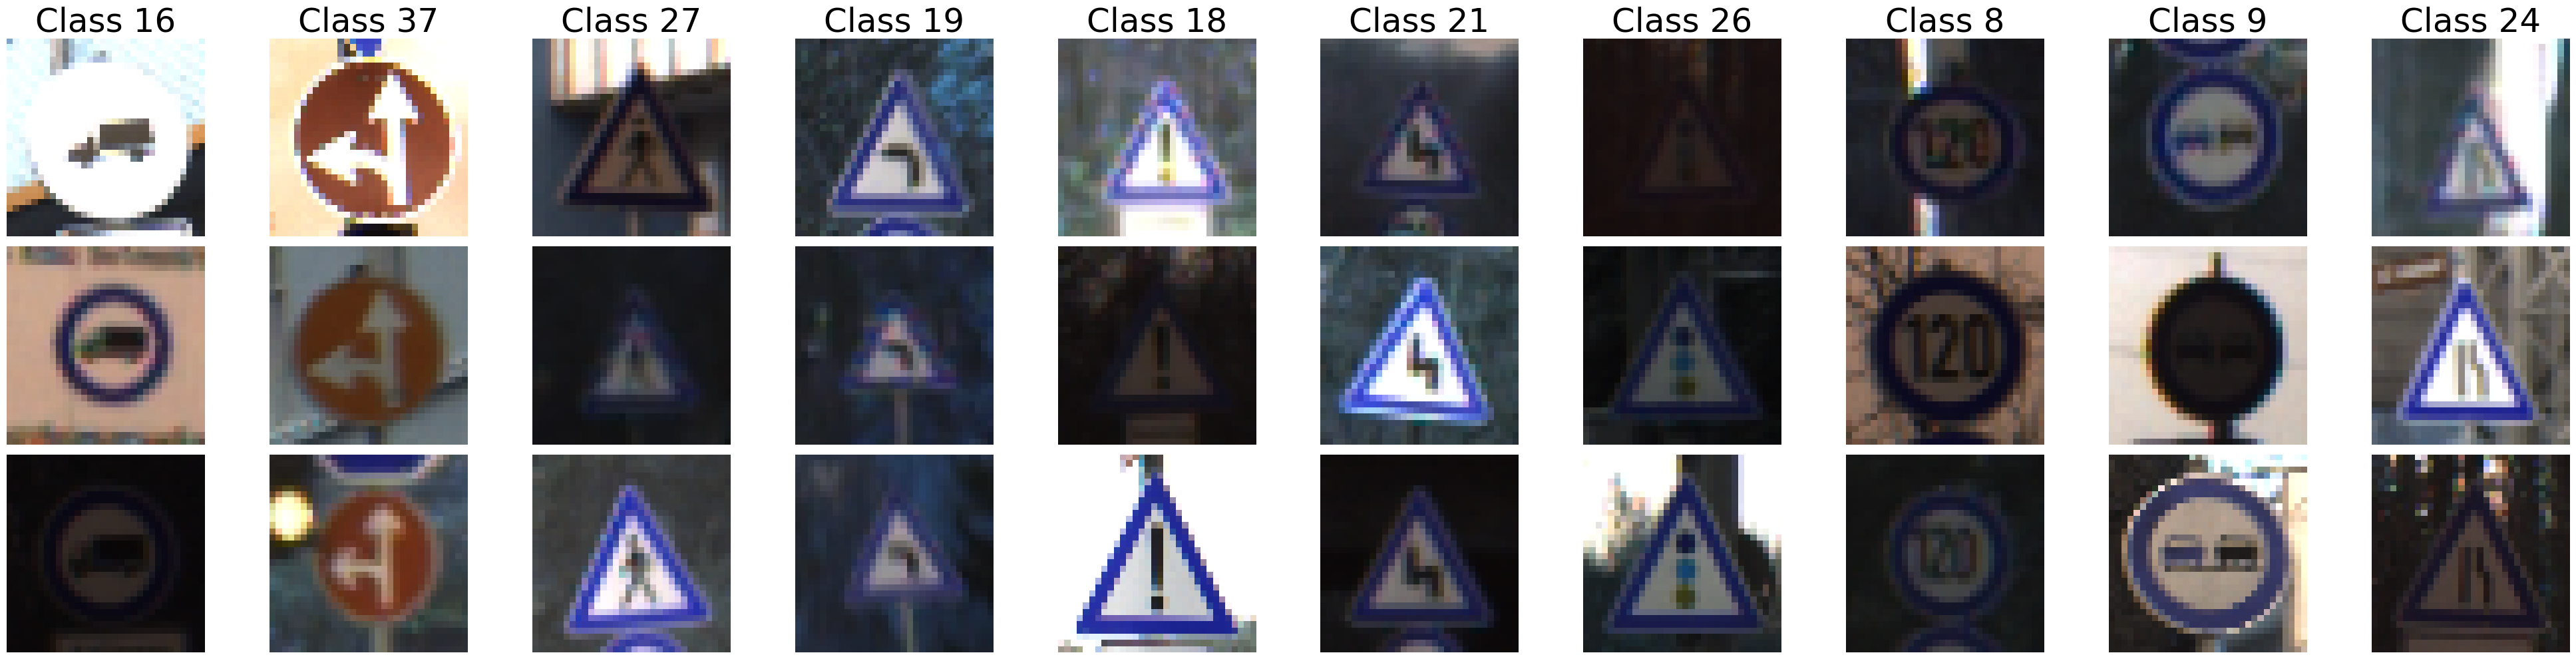

In [8]:
import random
import matplotlib.pyplot as plt

random_classes = random.sample(list(set(labels)), k=10)
fig, axes = plt.subplots(nrows=3, ncols=len(random_classes), figsize=(4 * len(random_classes), 10))


for i, class_id in enumerate(random_classes):
    class_indices = np.where(labels == class_id)[0]

    random_indices = random.sample(list(class_indices), k=3)
    axes[0, i].set_title(f"Class {class_id}", fontsize = 36)
    for j, image_index in enumerate(random_indices):
        image = images[image_index]
        axes[j, i].imshow(image)
        axes[j, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


<h2>2. Training and testing of model</h2>

The number of classes to be predicted/trained is set to be 43 which is the number of classes present in training dataset.

In [9]:
num_classes=43

The images and labels for training are splited into training and validation data. Their respecitive shape is checked:

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels)

In [11]:
print("Training dataset:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

Training dataset:
X_train shape: (19980, 32, 32, 3)
X_val shape: (6660, 32, 32, 3)
y_train shape: (19980,)
y_val shape: (6660,)


A function is defined to show the histories in training and validation accuracy. This is to access if the model overfit:

In [18]:
def plot_training_history(history):
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()

    plt.show()

<h3>Baseline model:</h3>

ResNet-50 is a specific variant of the ResNet (Residual Network) architecture. It is used commonly for image classification tasks. Thus, this will be implementing a transfered learning based on RestNet50 in attempt to achieve a higher accuracy:

In [24]:
base_model = ResNet50(include_top=False, input_shape=(32, 32, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('ResNet50model_checkpoint.h5', save_best_only=True)
RestNet50_model=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

395/395 [==============================] - 9s 21ms/step - loss: 0.4180 - accuracy: 0.9009
Test Loss: 0.4180200397968292
Test Accuracy: 0.9008709192276001


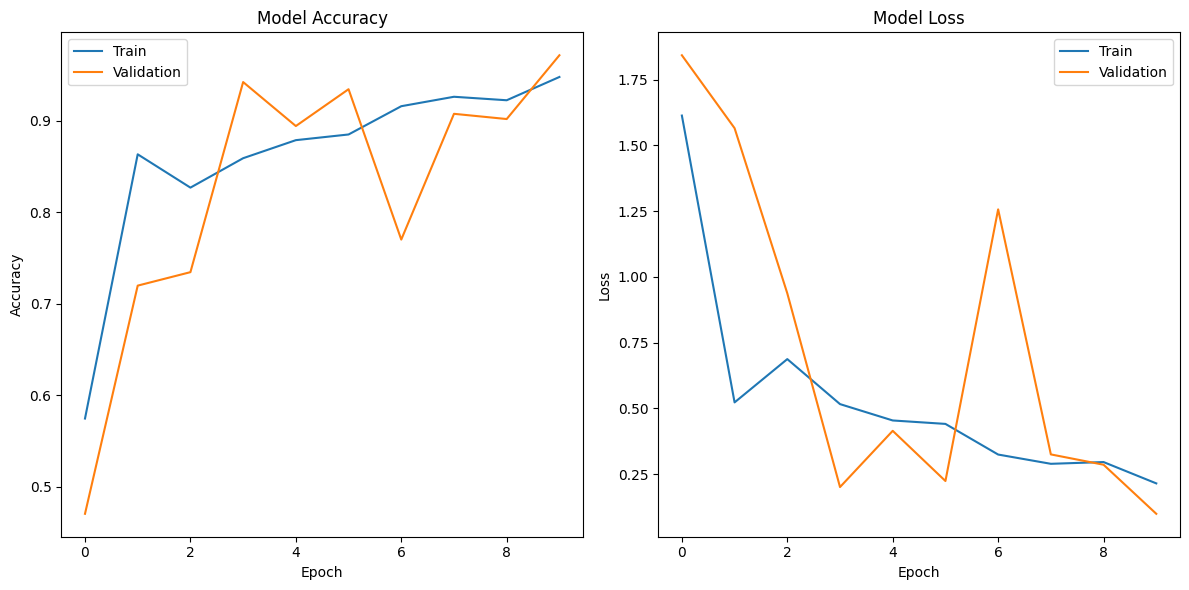

In [ ]:
plot_training_history(RestNet50_model)

In [ ]:
model.save('ResNet50model.h5')

<h3>Deploying CNN model:</h3>

Firstly, a model is defined for training a convolution neural network for a image classfication task.
Conv2D is used feature extraction in images, input shape is set as the size of the image (32)
Maxpooling2D is used for dimensonality reduction.
Flatten is used to change the infort format to 1D for dense layer.

The category is obtained using softmax activation to 43 classes (num_classes) on a dense layer.

Dropout were added but no regularisation is used yet.

In [12]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [14]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Train the model
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

num_epochs = 20
batch_size = 32
history_cnn = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 6s 6ms/step - loss: 1.2871 - accuracy: 0.6572 - val_loss: 0.3546 - val_accuracy: 0.9126
Epoch 2/20
625/625 [==============================] - 4s 6ms/step - loss: 0.2252 - accuracy: 0.9469 - val_loss: 0.1797 - val_accuracy: 0.9551
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 0.1103 - accuracy: 0.9737 - val_loss: 0.1599 - val_accuracy: 0.9638
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0755 - accuracy: 0.9817 - val_loss: 0.1401 - val_accuracy: 0.9664
Epoch 5/20
625/625 [==============================] - 3s 6ms/step - loss: 0.0462 - accuracy: 0.9882 - val_loss: 0.1058 - val_accuracy: 0.9775
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0380 - accuracy: 0.9907 - val_loss: 0.2183 - val_accuracy: 0.9503
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0289 - accuracy: 0.9924 - val_loss: 0.0821 - val_accuracy: 0.9883
Epoch 

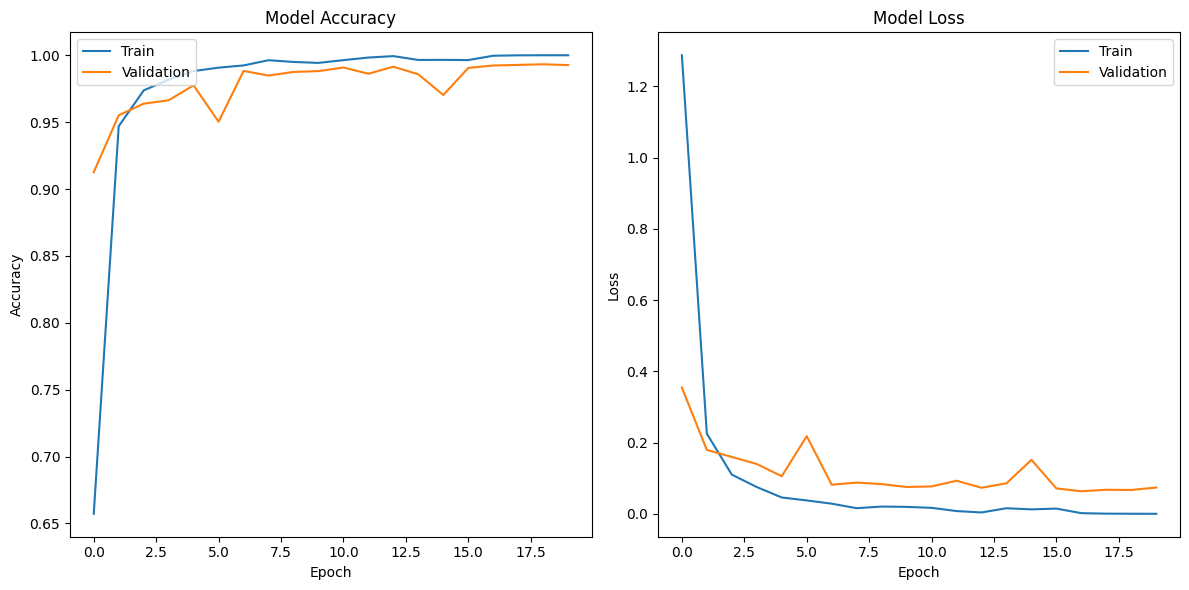

In [19]:
plot_training_history(history_cnn)

The model complexity can be <b>further increased</b> as the validation accuracy does not show a decrease.

In [20]:
# Evaluate the model
y_test_encoded = to_categorical(y_test, num_classes=num_classes)
_, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

395/395 [==============================] - 1s 3ms/step - loss: 0.6098 - accuracy: 0.9273
Test accuracy: 92.73%


In [21]:
model.save('cnn_model.h5')